# Import Modules

In [1]:
import glob
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import pandas as pd
from functools import partial
from tqdm.notebook import trange, tqdm
import umap
# import umap.plot 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys
sys.path.insert(0, os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE'))
from datasets import WCDataset, WCShotgunDataset, WC3dDataset

import plotly.express as px
import plotly.graph_objects as go

import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })

########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    if path in basepath:
        return basepath
    elif not os.path.exists(os.path.join(basepath, path)):
        os.makedirs(os.path.join(basepath, path))
        print('Added Directory:'+ os.path.join(basepath, path))
        return os.path.join(basepath, path)
    else:
        return os.path.join(basepath, path)

rootdir = os.path.expanduser('~/Research/FMEphys/')

# Set up partial functions for directory managing
join = partial(os.path.join,rootdir)
checkDir = partial(check_path,rootdir)
FigurePath = checkDir('Figures')

savefigs=False

# %matplotlib widget

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    plt.sca(last_axes)
    return cbar

def normimgs(comb,per_frame=False):
    if per_frame:
        comb = (comb - np.min(comb,axis=(-1,-2))[:,np.newaxis,np.newaxis])/(np.max(comb,axis=(-1,-2))-np.min(comb,axis=(-1,-2)))[:,np.newaxis,np.newaxis]
    else:
        comb = (comb - np.min(comb))/(np.max(comb)-np.min(comb))
    
    return (comb*255).astype(np.uint8)
# cmap = discrete_cmap(embedding.shape[0],base_cmap=plt.cm.jet)


In [3]:
# csv_path = os.path.expanduser('~/Research/Github/PyTorch-VAE/Completed_experiment_pool.csv')
# AllExps = pd.read_csv(csv_path)

# GoodExps = AllExps[(AllExps['Experiment outcome']=='good')].copy().reset_index()
# GoodExps = pd.concat((GoodExps[(GoodExps['Computer']=='kraken')][['Experiment date','Animal name','Computer','Drive']],
#                     GoodExps[(GoodExps['Computer']=='v2')][['Experiment date','Animal name','Computer','Drive']]))
# GoodExps['Experiment date'] = pd.to_datetime(GoodExps['Experiment date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%2m%2d%2y')
# GoodExps['Computer']=GoodExps['Computer'].str.capitalize()
# GoodExps.reset_index(inplace=True)

In [4]:
# tar --use-compress-program="pigz -k " -cf WCData.tar.gz ./012221_G6H30P3LN_control_Rig2_fm1_WORLD/ ./012521_EE8P6LT_control_Rig2_fm1_WORLD/ ./012621_EE8P6LT_control_Rig2_fm1_WORLD/ ./012821_EE8P6LT_control_Rig2_fm1_WORLD/ ./020121_EE13P1RT_control_Rig2_fm1_WORLD/ ./020321_EE13P1RT_control_Rig2_fm1_WORLD/ ./020821_EE12P1RN_control_Rig2_fm1_WORLD/ ./020921_EE12P1NN_control_Rig2_fm1_WORLD/ ./020921_EE12P1RN_control_Rig2_fm1_WORLD/ ./021121_EE12P1NN_control_Rig2_fm1_WORLD/ ./021521_EE11P11LT_control_Rig2_fm2_WORLD/ ./022321_EE12P1LN_control_Rig2_fm1_WORLD/ ./022421_EE13P2RT_control_Rig2_fm1_WORLD/ ./030821_EE8P7LT_control_Rig2_fm1_WORLD/ ./030821_EE8P7RT_control_Rig2_fm1_WORLD/ ./030921_EE11P13LTRN_control_Rig2_fm1_WORLD/ ./031021_EE11P13LTRN_control_Rig2_fm1_WORLD/ 

# Load Trained Network

In [3]:
from models.vanilla_vae import VanillaVAE
from models.vae_3dmp import VAE3dmp
from experiment import VAEXperiment
import yaml
import torchvision

In [6]:
glob.glob(os.path.expanduser('~/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/*.ckpt'))

['/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=3-step=28227.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=4-step=35284.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=5-step=42341.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=6-step=49398.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=9-step=70569.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=15-step=112911.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=20-step=148196.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=21-step=155253.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=26-step=190538.ckpt',
 '/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_1/checkpoints/epoch=31-step=225823.ckpt']

In [4]:
n = -1
version = 4
modeltype = '3dmp' # '3d'
if modeltype=='shotgun': 
    filename =  os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE','configs/WC_vae_shotgun.yaml')
    ckpt_path = glob.glob(os.path.expanduser('~/Research/FMEphys/logs2/VanillaVAE/version_3/checkpoints/*.ckpt'))[n]
elif modeltype=='vanilla':
    filename =  os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE','configs/WC_vae.yaml')
    ckpt_path = glob.glob(os.path.expanduser('~/Research/FMEphys/logs2/VanillaVAE/version_0/checkpoints/*.ckpt'))[n]
elif modeltype=='3d':
    filename =  os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE','configs/WC_vae3d.yaml')
    ckpt_path = glob.glob(os.path.expanduser('~/Research/FMEphys/logs2/VAE3d/version_4/checkpoints/*.ckpt'))[n]
elif modeltype=='3dmp':
    filename =  os.path.join(os.path.expanduser('~/Research/FMEphys/logs2/VAE3dmp/version_{:d}/WC_vae3dmp.yaml'.format(version)))
    ckpt_path = glob.glob(os.path.expanduser('~/Research/FMEphys/logs2/VAE3dmp/version_{:d}/checkpoints/*.ckpt'.format(version)))[n]
else:
    raise ValueError(f'{value} is not a valid model type')
print(ckpt_path)


with open(filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

if modeltype=='shotgun': 
    config['exp_params']['data_path'] = os.path.expanduser('~/Research/FMEphys/')
    config['exp_params']['csv_path_train'] = os.path.expanduser('~/Research/FMEphys//WCShotgun_Train_Data.csv')
    config['exp_params']['csv_path_val'] = os.path.expanduser('~/Research/FMEphys//WCShotgun_Val_Data.csv')
    config['logging_params']['save_dir'] = os.path.expanduser('~/Research/FMEphys/logs2/')
elif modeltype=='vanilla':
    config['exp_params']['data_path'] = os.path.expanduser('~/Research/FMEphys/')
    config['exp_params']['csv_path_train'] = os.path.expanduser('~/Research/FMEphys//WC_Train_Data.csv')
    config['exp_params']['csv_path_val'] = os.path.expanduser('~/Research/FMEphys//WC_Val_Data.csv')
    config['logging_params']['save_dir'] = os.path.expanduser('~/Research/FMEphys/logs2/')
elif (modeltype=='3d') | (modeltype=='3dmp'):
    config['exp_params']['data_path'] = os.path.expanduser('~/Research/FMEphys/data')
    config['exp_params']['csv_path_train'] = os.path.expanduser('~/Research/FMEphys/WC3d_Train_Data_SingVid.csv')
    config['exp_params']['csv_path_val'] = os.path.expanduser('~/Research/FMEphys/WC3d_Val_Data_SingVid.csv')
    config['logging_params']['save_dir'] = os.path.expanduser('~/Research/FMEphys/logs2/')
config


/home/eabe/Research/FMEphys/logs2/VAE3dmp/version_4/checkpoints/epoch=63-step=13631.ckpt


{'model_params': {'name': 'VAE3dmp',
  'in_channels': 1,
  'latent_dim': 64,
  'depth_dim': 16,
  'xystrides': [2, 2, 2, 2],
  'tstrides': [2, 2, 2, 2],
  'kernels': [5, 5, 5, 5],
  'mpkernels': [2, 2, 2, 2],
  'input_size': [1, 16, 64, 64],
  'hidden_dims': [32, 64, 128, 256]},
 'exp_params': {'dataset': 'WorldCam3D',
  'data_path': '/home/eabe/Research/FMEphys/data',
  'csv_path_train': '/home/eabe/Research/FMEphys/WC3d_Train_Data_SingVid.csv',
  'csv_path_val': '/home/eabe/Research/FMEphys/WC3d_Val_Data_SingVid.csv',
  'imgH_size': 64,
  'imgW_size': 64,
  'batch_size': 512,
  'LR': 0.001,
  'weight_decay': 0.0,
  'scheduler_gamma': 1,
  'N_fm': 16},
 'trainer_params': {'gpus': 1, 'max_epochs': 100},
 'logging_params': {'save_dir': '/home/eabe/Research/FMEphys/logs2/',
  'name': 'VAE3dmp',
  'manual_seed': 1265}}

In [6]:
if modeltype=='3d':
    model = VAE3d(**config['model_params'])
if modeltype=='3dmp':
    model = VAE3dmp(**config['model_params'])
else:
    model = VanillaVAE(**config['model_params'])
experiment = VAEXperiment(model,config['exp_params'])

experiment = experiment.load_from_checkpoint(ckpt_path,vae_model=model,params=config['exp_params'])
experiment.to(device)
print('Loaded')

Loaded


## Sample Batches

In [7]:
StartInd = 0
NumBatches= 100
config['exp_params']['batch_size'] = 90
if modeltype=='shotgun': 
    dataset = WCShotgunDataset(root_dir = config['exp_params']['data_path'],
                                csv_file = config['exp_params']['csv_path_train'],
                                N_fm=config['exp_params']['N_fm'],
                                transform=experiment.data_transforms())
elif modeltype=='vanilla':
    dataset = WCDataset(root_dir = config['exp_params']['data_path'],
                        csv_file = config['exp_params']['csv_path_train'],
                        transform=experiment.data_transforms())
elif (modeltype=='3d') | (modeltype=='3dmp'):
    dataset = WC3dDataset(root_dir = config['exp_params']['data_path'],
                                csv_file = config['exp_params']['csv_path_train'],
                                N_fm=config['exp_params']['N_fm'],
                                transform=experiment.data_transforms())
    
train_dataset = Subset(dataset,torch.arange(StartInd,StartInd+config['exp_params']['batch_size']*NumBatches)) # 107162
train_dataloader = DataLoader(train_dataset,
                              batch_size= config['exp_params']['batch_size'],
                              shuffle = False,
                              drop_last=False,
                              num_workers=7,
                              pin_memory=False,)

In [ ]:
zt = np.empty((NumBatches,config['exp_params']['batch_size'],config['model_params']['latent_dim']))
recont = np.empty((NumBatches,config['exp_params']['batch_size'],config['exp_params']['N_fm'],config['exp_params']['imgH_size'],config['exp_params']['imgW_size']), dtype=np.float32)
batcht = np.empty((NumBatches,config['exp_params']['batch_size'],config['exp_params']['N_fm'],config['exp_params']['imgH_size'],config['exp_params']['imgW_size']), dtype=np.float32)

with torch.no_grad():
    for n, batch in enumerate(tqdm(train_dataloader)):
        z,recon,inputs,_,_ = model.grab_latents(batch.to(device))
        zt[n] = z.cpu().detach().numpy()
        recont[n] = recon[:,0].cpu().numpy()
        batcht[n] = inputs[:,0].cpu().numpy()
del z, recon, inputs, batch
torch.cuda.empty_cache()
zt = zt.reshape(-1,config['model_params']['latent_dim'])
recont = recont.reshape(-1,config['exp_params']['N_fm'],config['exp_params']['imgH_size'],config['exp_params']['imgW_size'])
batcht = batcht.reshape(-1,config['exp_params']['N_fm'],config['exp_params']['imgH_size'],config['exp_params']['imgW_size'])

In [ ]:
batcht.shape,recont.shape,zt.shape

In [ ]:
# Plotting cube of input data (N_fm)
t = 800

plt.figure(figsize=(25,10))
plt.imshow(np.hstack(batcht[t]),cmap='gray')
plt.axis('off')
plt.figure(figsize=(25,10))
plt.imshow(np.hstack(recont[t]),cmap='gray')
plt.axis('off')

In [ ]:
len(dataset.data_paths[dataset.data_paths['BasePath']=='012221_G6H30P3LN_control_Rig2_fm1_WORLD'])

In [ ]:
107162/60

In [ ]:
# t=1600
# plt.figure(figsize=(10,10))
# plt.imshow(batcht[t,0],cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig(os.path.join(FigurePath,'ExampleFrame.png'))

# plt.figure(figsize=(10,10))
# plt.imshow(recont[t,0],cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig(os.path.join(FigurePath,'ExampleRecon.png'))

Added Directory:/home/eabe/Research/FMEphys/post_data/version_4


'/home/eabe/Research/FMEphys/post_data/version_4/zt_030921_EE11P13LTRN_control_Rig2_fm1_WORLD.npy'

False

# Visualizing Reconstuctions

In [ ]:
t=0
fig1, axs1 = plt.subplots(1,figsize=(20,50))
im_grid = torchvision.utils.make_grid(torch.Tensor(batcht[:,:1]),nrow=30,normalize=True)
axs1.imshow(im_grid.permute(1,2,0))
axs1.axis('off')
plt.tight_layout()

fig2, axs2 = plt.subplots(1,figsize=(20,50))
im_grid2 = torchvision.utils.make_grid(torch.Tensor(recont[:,:1]),nrow=30,normalize=True)
axs2.imshow(im_grid2.permute(1,2,0))
axs2.axis('off')
plt.tight_layout()

In [ ]:
savefigs=False
t=600
fig1, axs1 = plt.subplots(1,figsize=(20,10))
im_grid = torchvision.utils.make_grid(torch.Tensor(batcht[t:t+60,:1]),nrow=15,normalize=True)
axs1.imshow(im_grid.permute(1,2,0))
axs1.set_title('Frames')
axs1.axis('off')
plt.tight_layout()

fig2, axs2 = plt.subplots(1,figsize=(20,10))
im_grid2 = torchvision.utils.make_grid(torch.Tensor(recont[t:t+60,:1]),nrow=15,normalize=True)
axs2.imshow(im_grid2.permute(1,2,0))
axs2.set_title('Reconstructions')
axs2.axis('off')
plt.tight_layout()

if savefigs:
    fig1.savefig(os.path.join(FigurePath,'ExampleFrames.png'),dpi=fig2.dpi, bbox_inches='tight')
    fig2.savefig(os.path.join(FigurePath,'ReconFrames.png'),dpi=fig2.dpi, bbox_inches='tight')

## UMAP on Latent Space

In [ ]:
reducer = umap.UMAP(n_components=4)
# embedding = reducer.fit_transform(zt)

umapcomp = reducer.fit_transform(zt)

In [ ]:

fig = px.scatter_matrix(
    umapcomp,
    dimensions=range(4),
    color=np.arange(umapcomp.shape[0]),
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time'),
                  width=1000,
                  height=1000,
                  )
fig.show()

In [ ]:
t = 0
dt = umapcomp.shape[0]
fig = go.Figure(data=[go.Scatter3d(x=umapcomp[t:t+dt,0], y=umapcomp[t:t+dt,1], z=umapcomp[t:t+dt,2],
                                   mode='lines + markers',
                                   marker=dict(
                                                size=5,
                                                color=np.arange(umapcomp[t:t+dt,0].shape[0])/30,
                                                colorbar=dict(title='Time'),
                                                opacity=0.8),
                                   line=dict(
                                             color=np.arange(umapcomp[t:t+dt,0].shape[0])/30,
                                             width=2)
                                   )])
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time (s)'),
                  width=500,
                  height=500,
                  )
fig.show()

In [ ]:
t = 600
dt = 60 #umapcomp.shape[0]
comb = np.concatenate((batcht[t:t+dt,:1], recont[t:t+dt,:1]),axis=1)

fig = px.imshow(comb, animation_frame=0, facet_col=1, binary_string=True)
fig.update_layout(width=500,
                  height=500,
                 )
fig.show()

## UMAP Plot

In [ ]:
mapper = umap.UMAP().fit(zt)


In [ ]:
# umap.plot.points(mapper)
# umap.plot.connectivity(mapper, show_points=True)
umap.plot.connectivity(mapper, edge_bundling='hammer')


In [ ]:
umap.plot.connectivity(mapper, show_points=True)


## UMAP Testing on Frames

In [ ]:
batcht_flt = batcht.reshape(batcht.shape[0],-1)

In [ ]:
umapcomp = reducer.fit_transform(batcht_flt)

In [ ]:
fig = px.scatter_matrix(
    umapcomp,
    dimensions=range(4),
    color=np.arange(umapcomp.shape[0]),
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time'),
                  width=1000,
                  height=1000,
                  )
fig.show()

In [ ]:
t = 0
dt = umapcomp.shape[0]
fig = go.Figure(data=[go.Scatter3d(x=umapcomp[t:t+dt,0], y=umapcomp[t:t+dt,1], z=umapcomp[t:t+dt,2],
                                   mode='lines + markers',
                                   marker=dict(
                                                size=5,
                                                color=np.arange(umapcomp[t:t+dt,0].shape[0])/30,
                                                colorbar=dict(title='Time'),
                                                opacity=0.8),
                                   line=dict(
                                             color=np.arange(umapcomp[t:t+dt,0].shape[0])/30,
                                             width=2)
                                   )])
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time (s)'),
                  width=500,
                  height=500,
                  )
fig.show()

# Sample Testing

In [ ]:
pool = nn.MaxPool3d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool3d(2, stride=2)
testing = torch.randn(batch.shape)
output, indices = pool(testing)
unpooled_output = unpool(output, indices)
unpooled_output.size()

In [ ]:
z,recon,pool_idx, target_output_size,inputs,_,_ = model.grab_latents(batch.to(device))

In [ ]:
[temp.shape for temp in pool_idx], target_output_size

In [ ]:
num_samples = 30
target_output_size2 = [torch.Size([num_samples] + list(target_output_size[n][1:])) for n in range(len(target_output_size))]
pool_idx2 = pool_idx.copy()
z = torch.randn(num_samples,model.latent_dim)
z = z.to(device)
samples = model.decode(pool_idx2, target_output_size2, z)

In [ ]:
num_samples = 30
samples = model.sample(num_samples,device)

t=0
print(samples.shape)
fig, axs = plt.subplots(1,figsize=(25,15))
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=15,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Frames')
axs.axis('off')

# PCA of Latent Space

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
N_comp=128
pcaL = PCA(n_components=N_comp)

zcomps = pcaL.fit_transform(zt)

In [ ]:
exp_var_cumul = np.cumsum(pcaL.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

# ex_var = np.cumsum(pcaL.explained_variance_ratio_)
# th = np.where(ex_var>.80)[0][0]
# plt.plot(ex_var)
# plt.axvline(x=th,c='r')

In [ ]:
t = 600
dt = 600#umapcomp.shape[0]
fig = go.Figure(data=[go.Scatter3d(x=zcomps[t:t+dt,0], y=zcomps[t:t+dt,1], z=zcomps[t:t+dt,2],
                                   mode='lines + markers',
                                   marker=dict(
                                                size=5,
                                                color=np.arange(zcomps[t:t+dt,0].shape[0])/30,
                                                colorbar=dict(title='Time'),
                                                opacity=0.8),
                                   line=dict(
                                             color=np.arange(zcomps[t:t+dt,0].shape[0])/30,
                                             width=2)
                                   )])
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time (s)'),
                  width=500,
                  height=500,
                  )
fig.show()

In [ ]:
##### Sample from gaussian with cov of latent space #####
num_samples = 30
cov = np.cov(zt.T)
gauss_z = np.random.multivariate_normal(mean=np.mean(zt,axis=0),cov=cov,size=(30,))
z_gauss = torch.Tensor(gauss_z).to(device)
samples = model.generate_from_latents(z_gauss).cpu()

t=0
fig, axs = plt.subplots(1,figsize=(50,20))
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=15,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Cov Samples')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cov)
plt.colorbar()

In [ ]:
k = np.linalg.inv(cov)*sta

k = inverse cov * sta 

k*lat = pred_spks

In [ ]:
##### Taverse the top PC's #####
num_samples=30
target_output_size2 = [torch.Size([num_samples] + list(target_output_size[n][1:])) for n in range(len(target_output_size))]
pool_idx2 = pool_idx.copy()
dtrange = 2*pcaL.singular_values_[0]
dt = dtrange/100
n_comp_st = 0
n_comps = 5
epses = np.arange(-dtrange,dtrange,dt)
z_trav = [] 
for eps in epses:
    z_trav.append(pcaL.inverse_transform(zcomps[0] + np.sum([pcaL.components_[n]*eps for n in np.arange(n_comp_st,n_comps)],axis=0)))

with torch.no_grad():
    z = torch.Tensor(z_trav).to(device)
    samples = model.decode(pool_idx2,target_output_size2,z)

t=0
fig, axs = plt.subplots(1,figsize=(10,10))
# axs = axs.flatten()
# Image Frames
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=20,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Frames')
axs.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
fig = px.imshow(samples[:,0,0].cpu().detach().numpy(), animation_frame=0, binary_string=True)
fig.update_layout(width=500,
                  height=500,
                 )
fig.show()

# Latent Traversal

In [ ]:
np.std(zt,axis=0)

In [ ]:
##### Taverse componenets #####
num_samples=120
# target_output_size2 = [torch.Size([num_samples] + list(target_output_size[n][1:])) for n in range(len(target_output_size))]
# pool_idx2 = pool_idx.copy()
dtrange = 2
dt = dtrange/num_samples
epses = np.arange(-dtrange,dtrange,dt)
z_trav = [] 
z_temp = np.zeros(zt[:1,:].shape)#zt[:1,:]# np.random.randn(1,model.latent_dim)
comp = 98
for eps in epses:
    tempadd = np.zeros_like(z_temp)
    tempadd[:,comp] = eps
    z_trav.append(z_temp + tempadd)

with torch.no_grad():
    with torch.cuda.amp.autocast():
        z = torch.Tensor(z_trav).to(device)
        samples = model.generate_from_latents(z)

t=7
fig, axs = plt.subplots(1,figsize=(10,8))
# axs = axs.flatten()
# Image Frames
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=20,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Frames')
axs.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

##### Taverse componenets #####
num_samples=120
# target_output_size2 = [torch.Size([num_samples] + list(target_output_size[n][1:])) for n in range(len(target_output_size))]
# pool_idx2 = pool_idx.copy()
dtrange = 10
dt = dtrange/num_samples
epses = np.arange(-dtrange,dtrange,dt)
tot_samps = np.zeros((128,240,64,64)) # Comp x Trav x H x W
# with PdfPages(os.path.join(FigurePath,'Latent_traversal.pdf')) as pdf:
for comp in range(128):
    z_trav = [] 
    z_temp = zt[:1,:]-np.mean(zt,axis=0)# np.random.randn(1,model.latent_dim) # np.zeros(zt[:1,:].shape)#
    for eps in epses:
        tempadd = np.zeros_like(z_temp)
        tempadd[:,comp] = eps
        z_trav.append(z_temp + tempadd)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            z = torch.Tensor(z_trav).to(device)
            samples = model.generate_from_latents(z)

    tot_samps[comp] = samples[:,0,0].cpu().numpy()
    fig, axs = plt.subplots(1,figsize=(10,10))
    # axs = axs.flatten()
    # Image Frames
    im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=20,normalize=True)
    axs.imshow(im_grid.permute(1,2,0))
    axs.set_title('Latent Traversal: {}'.format(comp))
    axs.axis('off')
    plt.tight_layout()
#         plt.show()
#         pdf.savefig(fig)
    plt.close()
    del samples,z
    torch.cuda.empty_cache()

In [ ]:
np.save(os.path.join(rootdir,'lat_samps.npy'),tot_samps)

In [ ]:
st=60
sp=st+20
samps = tot_samps[st:sp]
fig = px.imshow(samps, animation_frame=1,facet_col=0, binary_string=True,facet_col_spacing=0.007873, facet_col_wrap=5)
fig.update_layout(width=1000,
                  height=1000)
# Set facet titles
for i, n in enumerate(range(st,st+samps.shape[0])):
    fig.layout.annotations[i]['text'] = '%d' %n
fig.show()

In [ ]:
z = torch.Tensor(pcaL.components_).to(device)
samples = model.decode(z)
t=0
fig, axs = plt.subplots(1,figsize=(50,20))
# axs = axs.flatten()
# Image Frames
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=20,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('PCA Comp Deocded')

# PCA Testing on Image Frames

PCA on latent space vary top PC smoothly and decode. Then use covarience matrix from PCA to sample from normal distrubtion. 

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
b2 = batcht[:,:1].reshape(batcht.shape[0],-1)

N_comp=128
pca = PCA(n_components=N_comp)

components = pca.fit_transform(b2)

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

# ex_var = np.cumsum(pcaL.explained_variance_ratio_)
# th = np.where(ex_var>.80)[0][0]
# plt.plot(ex_var)
# plt.axvline(x=th,c='r')

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=np.arange(b2.shape[0]),
   
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time'),
                  width=1000,
                  height=1000,
                  )
fig.show()

In [ ]:
t = 0
dt = components.shape[0]
comps_t = components[t:t+dt]
fig = go.Figure(data=[go.Scatter3d(x=comps_t[:,0], y=comps_t[:,1], z=comps_t[:,2],
                                   mode='lines + markers',
                                   marker=dict(
                                                size=5,
                                                color=np.arange(comps_t[:,0].shape[0])/30,
                                                colorbar=dict(title='Time'),
                                                opacity=0.8),
                                   line=dict(
                                             color=np.arange(comps_t[:,0].shape[0]),
                                             width=2),
                                   
                                   )],)
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time'),
                  width=500,
                  height=500,
                  )
fig.show()

In [ ]:
batcht.shape, components.shape, img2.shape

In [ ]:
img2 = pca.inverse_transform(components)
img2 = img2.reshape(batcht.shape[0],batcht.shape[-2],batcht.shape[-1])
comp = pca.components_.reshape(128,64,64)

In [ ]:
t=0
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs = axs.flatten()
# Image Frames
im_grid = torchvision.utils.make_grid(torch.Tensor(batcht[t:t+50,:1]),nrow=10,normalize=True)
axs[0].imshow(im_grid.permute(1,2,0))
axs[0].set_title('Frames')

# PCA Reconstuction
im_grid2 = torchvision.utils.make_grid(torch.Tensor(img2[t:t+50,np.newaxis]),nrow=10,normalize=True)
axs[1].imshow(im_grid2.permute(1,2,0))
axs[1].set_title('PCA Recon')


im_grid3 = torchvision.utils.make_grid(torch.Tensor(comp[:,np.newaxis,:,:]),nrow=20,normalize=True)
axs[3].imshow(im_grid3.permute(1,2,0))
axs[3].set_title('PCA Components')

plt.tight_layout()
plt.show()

# Videos

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib import colors

In [ ]:
import cv2

In [ ]:
# Combined Frame and Latent Video
t = 0
dt = batcht.shape[0]

comb = normimgs(np.concatenate((batcht[t:t+dt,:1], recont[t:t+dt,:1]),axis=3).squeeze())

FPS = 60
out = cv2.VideoWriter(os.path.join(FigurePath,'CombVid5.avi'), cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), FPS, (comb.shape[-1], comb.shape[-2]),0)
            
for fm in tqdm(range(comb.shape[0])):
    out.write(comb[fm])
out.release()

In [ ]:
# Example Frames Video
t = 0
dt = 1200#umapcomp.shape[0]
comb = normimgs(batcht[t:t+dt,:1].squeeze())
# comb = (comb - np.min(comb,axis=(-1,-2))[:,np.newaxis,np.newaxis])/(np.max(comb,axis=(-1,-2))-np.min(comb,axis=(-1,-2)))[:,np.newaxis,np.newaxis]
# comb = (comb*255).astype(np.uint8)

FPS = 60
out = cv2.VideoWriter(os.path.join(FigurePath,'Frames_ExVid.avi'), cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), FPS, (comb.shape[-1], comb.shape[-2]),0)
            
for fm in tqdm(range(comb.shape[0])):
    out.write(comb[fm])
out.release()

In [ ]:
# Combined Frame and Latent Video
t = 0
dt = 600#batcht.shape[0]
comb = np.concatenate((batcht[t:t+dt:3,:1], recont[t:t+dt:3,:1]),axis=3).squeeze()
umapcomp2 = umapcomp[t:t+dt:3,:].copy()

In [ ]:
def init():
    axs[0].axis('off')
    axs[1].set_xlim([np.min(umapcomp2[:,0]),np.max(umapcomp2[:,0])])
    axs[1].set_ylim([np.min(umapcomp2[:,1]),np.max(umapcomp2[:,1])])
    plt.tight_layout()

def update(t):
    x.append(umapcomp2[t,0])
    y.append(umapcomp2[t,1])
    ln1.set_data(x,y)
    ln2.set_offsets((umapcomp2[t,0],umapcomp2[t,1]))
    im1.set_data(comb[t])
    plt.draw()

In [ ]:
t = 0
x,y = [],[]
fig, axs = plt.subplots(1,2,figsize=(10,5))  
axs = axs.flatten()
im1 = axs[0].imshow(comb[0],cmap='gray',norm=colors.Normalize())
axs[0].axis('off')
ln1, = axs[1].plot([],[], '.-')
ln2 = axs[1].scatter([],[], c='red')
axs[1].set_xlim([np.min(umapcomp[:,0]),np.max(umapcomp[:,0])])
axs[1].set_ylim([np.min(umapcomp[:,1]),np.max(umapcomp[:,1])])
plt.tight_layout()


In [ ]:
ani = FuncAnimation(fig, update, range(comb.shape[0]), init_func=init)  
plt.show()

In [ ]:
writer = PillowWriter(fps=60)  
ani.save(os.path.join(FigurePath,"DemoAni1.gif"), writer=writer) 

## Latent Traversal Vid

In [ ]:
torch.cuda.empty_cache()
z.shape

In [ ]:
plt.plot(np.mean(zt,axis=0).T)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
##### Taverse componenets #####
num_samples=120
dtrange = np.round(2*np.std(zt,axis=0))
# dtrange = np.ones(32)*2
tot_samps = np.zeros((config['model_params']['latent_dim'],num_samples*2,config['exp_params']['imgH_size'],config['exp_params']['imgW_size'])) # Comp x Trav x H x W
# with PdfPages(os.path.join(FigurePath,'Latent_traversal.pdf')) as pdf:
for comp in trange(config['model_params']['latent_dim']):
    dt = dtrange[comp]/num_samples
    epses = np.arange(-dtrange[comp],dtrange[comp],dt)
    z_trav = [] 
    z_temp = np.zeros((config['model_params']['latent_dim']))#zt[:1,:]-np.mean(zt,axis=0)# np.random.randn(1,model.latent_dim) # 
    for eps in epses:
        tempadd = np.zeros_like(z_temp)
        tempadd[comp] = eps
        z_trav.append(z_temp + tempadd)

    with torch.no_grad():
        z = torch.Tensor(z_trav).to(device)
        samples = model.generate_from_latents(z)

    tot_samps[comp] = samples[:,0,0].cpu().numpy()
#     fig, axs = plt.subplots(1,figsize=(10,10))
    # axs = axs.flatten()
    # Image Frames
#     im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=20,normalize=True)
#     axs.imshow(im_grid.permute(1,2,0))
#     axs.set_title('Latent Traversal: {}'.format(comp))
#     axs.axis('off')
#     plt.tight_layout()
# #         plt.show()
# #         pdf.savefig(fig)
#     plt.close()
    del samples,z
    torch.cuda.empty_cache()

In [ ]:
tot_samps.shape

In [ ]:
save_lats = check_path(rootdir,'LatentTravs/version_{:d}'.format(version))
np.save(os.path.join(save_lats,'LatTrav_{}_range{:d}.mp4'.format(dataset.data_paths['BasePath'][StartInd],int(dtrange[0]))),tot_samps)
# tot_samps = np.load(os.path.join(save_lats,'LatTrav_{:d}.npy'.format(dtrange)))

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib import colors
def init():
    for n in range(config['model_params']['latent_dim']):
        axs[n].axis('off')
    plt.tight_layout()

def update(t):
    for n in range(config['model_params']['latent_dim']):
        ims[n].set_data(tot_samps[n,t])
    plt.draw()

In [ ]:
t = 0
lat_dims = config['model_params']['latent_dim']
x,y = [],[]
fig, axs = plt.subplots(int(np.round(np.sqrt(lat_dims))),int(np.ceil(np.sqrt(lat_dims))),figsize=(15,15))   #8,16,figsize=(50,30)  
axs = axs.flatten()
ims = []
for n in range(config['model_params']['latent_dim']):
    ims.append(axs[n].imshow(tot_samps[n,t],cmap='gray',norm=colors.Normalize()))
    axs[n].axis('off')
    axs[n].set_title('{:d}'.format(n))
plt.tight_layout()
# fig.savefig(os.path.join(FigurePath,'testimg.png'))

In [ ]:
ani = FuncAnimation(fig, update, range(tot_samps.shape[1]), init_func=init)  
plt.show()

In [ ]:
# writervideo = PillowWriter(fps=60)  
vpath = check_path(FigurePath,'version_{:d}'.format(version))
writervideo = FFMpegWriter(fps=60) 
ani.save(os.path.join(vpath,'LatTrav_{}_range{:d}.mp4'.format(dataset.data_paths['BasePath'][StartInd],int(dtrange[0]))), writer=writervideo,
progress_callback=lambda i, n: print(f'Saving frame {i} of {n}')) 

In [ ]:
os.path.join(postdir,'zt_{}.npy'.format(dataset.data_paths['BasePath'][StartInd]))

# Load Ephys

In [13]:
from scipy.interpolate import interp1d

In [8]:
postdir = check_path(rootdir,'post_data/version_{:d}'.format(version))

zt = np.load(os.path.join(postdir,'zt_{}.npy'.format(dataset.data_paths['BasePath'][StartInd])))

In [15]:
nframes = zt.shape[0]
ephys_path = glob.glob(os.path.join(rootdir,'data',dataset.data_paths['BasePath'][StartInd][:-5] + 'ephys','*merge.json'))[0]
TS_path = glob.glob(os.path.join(rootdir,'data',dataset.data_paths['BasePath'][StartInd][:-5] + 'ephys','*TSformatted.csv'))[0]
ephys_df = pd.read_json(ephys_path)
worldT = pd.read_csv(TS_path)['0']
worldT = worldT[StartInd:nframes] - ephys_df['t0'][0]
if worldT[0]<-600:
    worldT = worldT + 8*60*60

good_cells = ephys_df[ephys_df['group']=='good']
n_units = len(good_cells)

# world_cam = batch[:,0].cpu().detach().numpy().copy()
# world_norm = normimgs(world_cam)

In [16]:
model_dt = 0.025;
model_t = np.arange(0,np.max(worldT),model_dt)
model_nsp = np.zeros((len(good_cells),len(model_t)))

# get spikes / rate
bins = np.append(model_t,model_t[-1]+model_dt)
for i,ind in enumerate(good_cells.index):
    model_nsp[i,:],bins = np.histogram(good_cells.at[ind,'spikeT'],bins)


In [60]:
# Set up interp for latents

# movInterp = interp1d(worldT,world_norm.reshape(nframes,-1),axis=0, bounds_error = False)
latInterp = interp1d(worldT,zt,axis=0, bounds_error = False,kind='nearest')
# latInterp = NearestNDInterpolator(np.repeat(worldT.to_numpy(),[128],axis=0).reshape(worldT.shape[0],-1),zt)

nks = config['model_params']['input_size'][1:]; nk = nks[0]*nks[1];    
# model_vid = np.zeros((len(model_t),nk))
model_lat = np.zeros((len(model_t),config['model_params']['latent_dim']))
for i in trange(len(model_t)):
#     model_vid[i] = np.reshape(movInterp(model_t[i] + model_dt/2),nk)
    model_lat[i] = latInterp(model_t[i] + model_dt/2)
model_lat[np.isnan(model_lat)]=0;
# model_vid[np.isnan(model_vid)]=0;
model_lat = np.concatenate((model_lat, np.ones(model_lat.shape[0]),1), axis=1)

  0%|          | 0/72573 [00:00<?, ?it/s]

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [59]:
np.ones(model_lat.shape[0]).shape

(72573,)

In [52]:
# lagRange = np.arange(-2,8,2) #[-30] #
lagRange = np.concatenate(([-30],np.arange(-2,8,2)),axis=0)
stalat = np.zeros((n_units,len(lagRange),config['model_params']['latent_dim']))

for c, ind in enumerate(good_cells.index):
    for  lagInd, lag in enumerate(lagRange):
        sp = model_nsp[c,:].copy();
        nsp = np.sum(sp)
        sp = np.roll(sp,-lag)
        sta = model_lat.T@sp
        stalat[c,lagInd] = sta/nsp
    print(f'Cell:{ind}, nspks:{nsp}')

Cell:7, nspks:3402.0
Cell:13, nspks:2056.0
Cell:15, nspks:13379.0
Cell:16, nspks:82167.0
Cell:18, nspks:31130.0
Cell:20, nspks:5092.0
Cell:24, nspks:24427.0
Cell:25, nspks:23703.0
Cell:35, nspks:17702.0
Cell:39, nspks:52656.0
Cell:46, nspks:78387.0
Cell:47, nspks:700.0
Cell:48, nspks:3316.0
Cell:58, nspks:93288.0
Cell:63, nspks:5504.0
Cell:65, nspks:73758.0
Cell:74, nspks:3287.0
Cell:77, nspks:44888.0
Cell:78, nspks:24678.0
Cell:82, nspks:15698.0


In [48]:
sta_shape = stalat.shape
stalat = stalat.reshape(-1,sta_shape[-1])

In [49]:
stalat = stalat - np.mean(zt,axis=0)

In [21]:
stalat.shape

(120, 64)

In [50]:

 ##### Push through decoder #####
num_samples = stalat.shape[0]
sta_z = torch.Tensor(stalat).to(device)
with torch.no_grad():
    samples = model.generate_from_latents(sta_z)

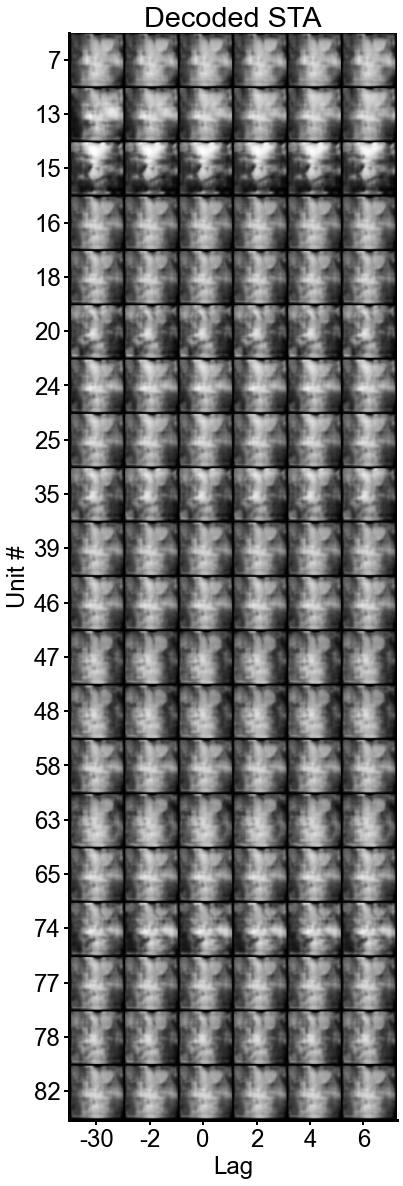

In [51]:
fig, axs = plt.subplots(1,figsize=(10,20))
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=len(lagRange),normalize=True).cpu()
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Decoded STA')
# axs.xaxis.set_ticks_position('top')
axs.set_xticks(np.arange(32,im_grid.shape[-1],65))
axs.set_xticklabels(lagRange)
axs.set_xlabel('Lag')
# axs.xaxis.set_label_position('top') # <-- This doesn't work!
axs.set_yticks(np.arange(32,im_grid.shape[-2],66))
axs.set_yticklabels(good_cells.index)
axs.set_ylabel('Unit #')
plt.show()
fig.savefig(os.path.join(FigurePath,'STA_128Model.png'))

In [ ]:
model_lat.shape, model_nsp.shape

In [ ]:
print(torch.cuda.memory_summary())

In [ ]:
torch.cuda.empty_cache()

In [ ]:
t = 400
dt = 200
c = 1
z_temp = model_lat[model_nsp[c,:]>0,:]
z_temp2 = z_temp[t:t+dt].copy()
sta_z = torch.tensor(z_temp2, requires_grad=False, dtype=torch.float32).to(device)
with torch.no_grad():
    samples = model.generate_from_latents(sta_z)

In [ ]:
fig, axs = plt.subplots(1,figsize=(25,25))
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=10,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Decoded latent')
# axs.xaxis.set_ticks_position('top')
axs.set_xticks(np.arange(32,im_grid.shape[-1],65))
# axs.set_xticklabels(lagRange)
axs.set_xlabel('Lag')
# axs.xaxis.set_label_position('top') # <-- This doesn't work!
axs.set_yticks(np.arange(32,im_grid.shape[-2],66))
# axs.set_yticklabels(good_cells.index)
axs.set_ylabel('Unit #')
plt.show()

In [ ]:
stalat.reshape(n_units,len(lagRange),-1)[:,0].T.shape

In [ ]:
plt.plot(stalat.reshape(n_units,len(lagRange),-1)[:,0].T)
plt.plot(np.mean(zt,axis=0),'r',LineWidth=3)

In [ ]:
plt.plot(zt[0])

In [ ]:
stalat.shape

In [ ]:
umap_lat = reducer.transform(stalat)

In [ ]:

fig = px.scatter_matrix(
    umap_lat,
    dimensions=range(4),
    color=np.arange(umap_lat.shape[0]),
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='Time'),
                  width=1000,
                  height=1000,
                  )
fig.show()

In [ ]:
dataset.data_paths[dataset.data_paths['BasePath']=='012221_G6H30P3LN_control_Rig2_fm1_WORLD']

## GLM predictions on firing rate

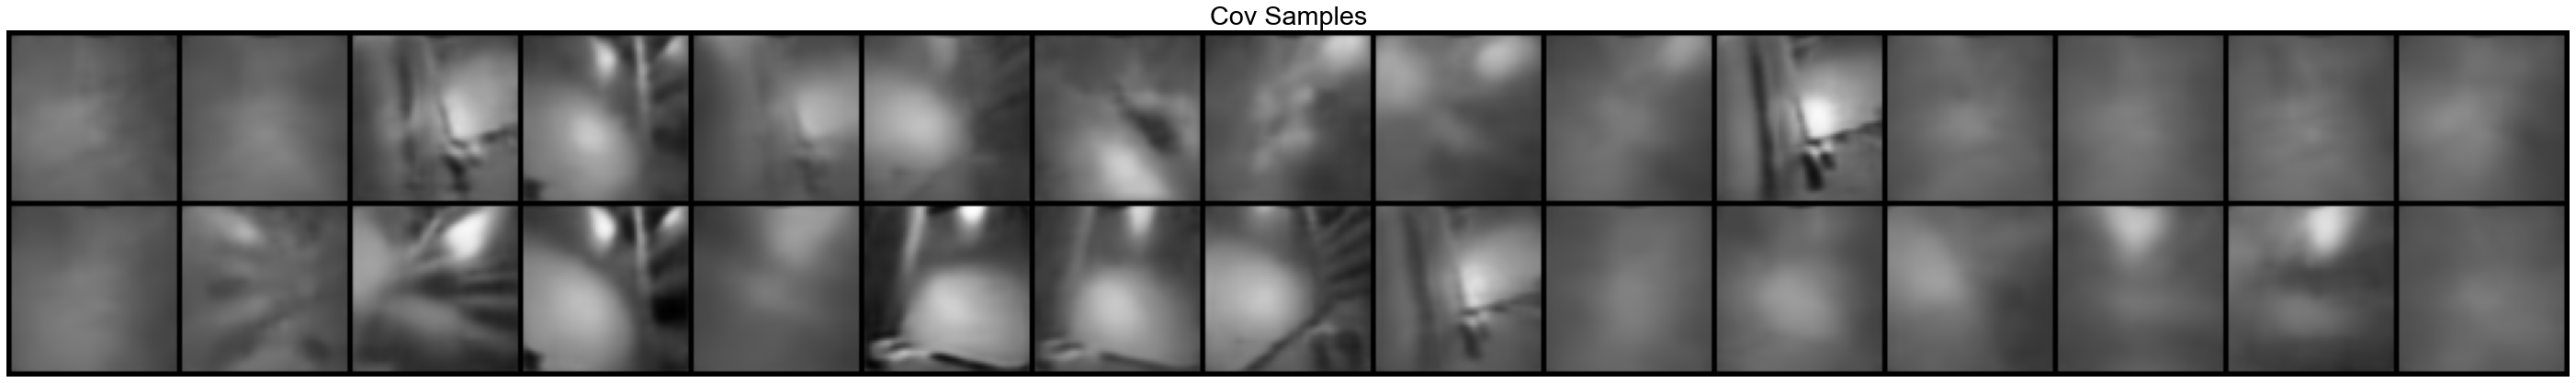

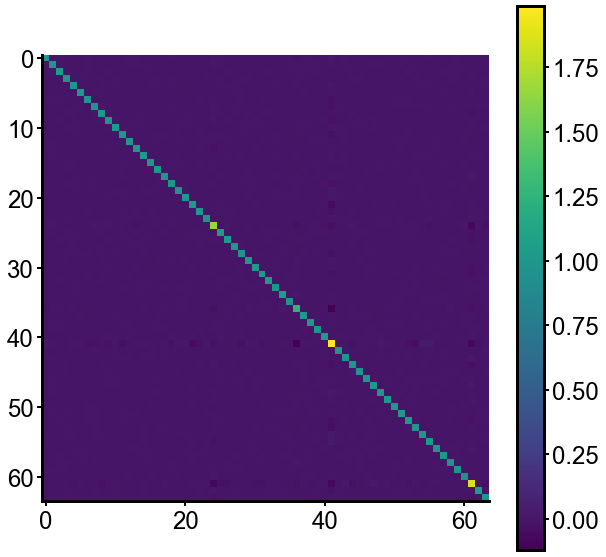

In [61]:
##### Sample from gaussian with cov of latent space #####
num_samples = 60
cov = np.cov(zt.T)
gauss_z = np.random.multivariate_normal(mean=np.mean(zt,axis=0),cov=cov,size=(30,))
z_gauss = torch.Tensor(gauss_z).to(device)
samples = model.generate_from_latents(z_gauss).cpu()

t=0
fig, axs = plt.subplots(1,figsize=(50,20))
im_grid = torchvision.utils.make_grid(samples[:,0,:1].cpu(),nrow=15,normalize=True)
axs.imshow(im_grid.permute(1,2,0))
axs.set_title('Cov Samples')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(cov)
plt.colorbar()

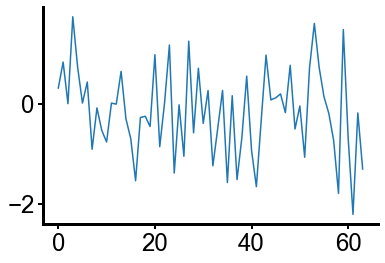

In [65]:
plt.plot(z_gauss[17].cpu())

In [25]:
from sklearn.metrics import r2_score

In [53]:
cellnum = 1
lagnum = 3
k = np.linalg.inv(cov)@stalat[cellnum,lagnum]

In [30]:
stalat.shape

(20, 6, 64)

In [31]:
model_nsp.shape,model_lat.shape

((20, 72573), (72573, 64))

In [54]:
lagnum = 1
scores = np.empty(stalat.shape[0])
pred_spks = np.empty((stalat.shape[0],model_lat.shape[0]))
for cellnum in trange(stalat.shape[0]):
#     for lagnum in range(lagRange.shape[0]):
    k = np.linalg.inv(cov)@stalat[cellnum,lagnum]
    for t in range(model_lat.shape[0]):
        pred_spks[cellnum,t] = k@model_lat[t]
    scores[cellnum] = r2_score(model_nsp[cellnum], pred_spks[lagnum])
#     plt.plot(pred_spks[lagnum,:100].T,alpha=.3) #np.clip(pred_spks,a_min=0,a_max=100)[:100])


  0%|          | 0/20 [00:00<?, ?it/s]

array([-0.07318795, -2.21602694, -0.47415961, -1.44266022, -0.58160779,
       -1.26892904, -0.7263262 , -0.65679674, -0.75463538, -0.84330495,
       -1.13653366, -9.54843883, -2.04070863, -1.29115014, -0.94543102,
       -1.06376399, -1.75170598, -0.82281279, -0.66772082, -0.6384523 ])

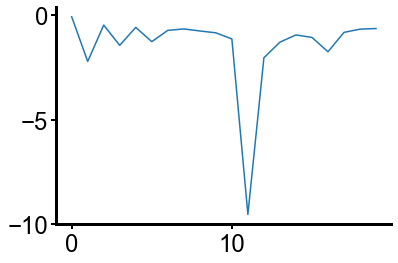

In [33]:
plt.plot(scores)
scores

In [ ]:
model_nsp.shape, model_lat.shape

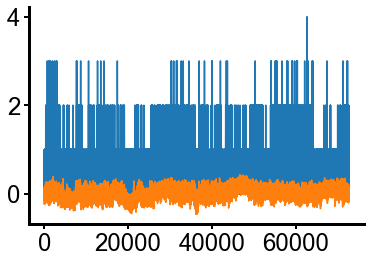

In [55]:
plt.plot(model_nsp[cellnum])
plt.plot(pred_spks[cellnum])

k = inverse cov * sta 

k*lat = pred_spks

## Move Ephys Data

In [ ]:
import shutil

csv_path = os.path.expanduser('~/Research/FMEphys/Completed_experiment_pool2.csv')
AllExps = pd.read_csv(csv_path)

GoodExps = AllExps[(AllExps['experiment_outcome']=='good')].copy().reset_index()
GoodExps = GoodExps[(GoodExps['computer']=='goeppert')][['experiment_date','animal_name','computer','drive']]
GoodExps['experiment_date'] = pd.to_datetime(GoodExps['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%2m%2d%2y')
GoodExps['computer']=GoodExps['computer'].str.capitalize()
print('Number of Experiments:', len(GoodExps))

for n in range(len(GoodExps)):
    Comp=GoodExps['computer'][n]
    Drive=GoodExps['drive'][n]
    Date=GoodExps['experiment_date'][n]
    Ani=GoodExps['animal_name'][n]
    EphysPath = os.path.join(os.path.expanduser('~/'),Comp,'freely_moving_ephys/ephys_recordings',Date,Ani,'fm1','*merge.json')
    TSPath = os.path.join(os.path.expanduser('~/'),Comp,'freely_moving_ephys/ephys_recordings',Date,Ani,'fm1','*WORLD_BonsaiTSformatted.csv')

    FM1Cam = glob.glob(EphysPath)
    TSFile = glob.glob(TSPath)
#     dir_name = '_'.join(os.path.basename(TSFile[0]).split('_')[:-1])
    if len(FM1Cam) > 0:
        SavePath = os.path.join(check_path(os.path.join(rootdir,'data'),os.path.basename(FM1Cam[0])[:-11]))
        shutil.copyfile(FM1Cam[0], os.path.join(SavePath,os.path.basename(FM1Cam[0])), follow_symlinks=True)
    if len(TSFile) > 0:
        try:
            SavePath = os.path.join(check_path(os.path.join(rootdir,'data'),os.path.basename(FM1Cam[0])[:-11]))
            shutil.copyfile(TSFile[0], os.path.join(SavePath,os.path.basename(TSFile[0])), follow_symlinks=True)
        except:
            pass

In [ ]:
import gc, psutil
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()
memReport()

# Conv Dimensions Checking

In [ ]:
def calc_out_dims(inshape,Cout,dialation=1,ksize=1,stride=1,padding=1):
    if type(ksize) == int:
        ksize = (ksize,ksize,ksize)
    if type(dialation) == int:
        dialation = (dialation,dialation,dialation)
    if type(stride) == int:
        stride = (stride,stride,stride)
    if type(padding) == int:
        padding = (padding,padding,padding)

    C,D,H,W = inshape
    Dout = int(((D + 2*padding[0] - dialation[0]*(ksize[0]-1)-1)/stride[0]) + 1)
    Hout = int(((H + 2*padding[1] - dialation[1]*(ksize[1]-1)-1)/stride[1]) + 1)
    Wout = int(((W + 2*padding[2] - dialation[2]*(ksize[2]-1)-1)/stride[2]) + 1)
    return (Cout,Dout,Hout,Wout)

hidden_dims = [16, 32, 64, 128, 256]
xystrides = [2,2,2,2,2]
tstrides = [2,2,2,2,1]
kernels = [5,5,5,5,5]
mpkernels = [2,2,2,2,1]
inshape = (1,16,128,128)
print(inshape)
outshapes = []

for i in range(len(hidden_dims)):
    outshape1 = calc_out_dims(inshape,hidden_dims[i],ksize=kernels[i],stride=1,padding=2)
    outshape = calc_out_dims(outshape1,hidden_dims[i],ksize=mpkernels[i],stride=(tstrides[i],xystrides[i],xystrides[i]),padding=0)
    inshape = outshape
    outshapes.append(outshape)
print(outshapes)

In [ ]:
def calc_out_dims_trans(inshape,Cout,dialation=1,ksize=1,stride=1,padding=1,output_padding=0):
    if type(ksize) == int:
        ksize = (ksize,ksize,ksize)
    if type(dialation) == int:
        dialation = (dialation,dialation,dialation)
    if type(stride) == int:
        stride = (stride,stride,stride)
    if type(padding) == int:
        padding = (padding,padding,padding)
    if type(output_padding) == int:
        output_padding = (output_padding,output_padding,output_padding)

    C,D,H,W = inshape
    Dout = int((((D - 1)*stride[0] - 2*padding[0] + dialation[0]*(ksize[0]-1) + output_padding[0])) + 1)
    Hout = int((((H - 1)*stride[1] - 2*padding[1] + dialation[1]*(ksize[1]-1) + output_padding[1])) + 1)
    Wout = int((((W - 1)*stride[2] - 2*padding[2] + dialation[2]*(ksize[2]-1) + output_padding[2])) + 1)
    return (Cout,Dout,Hout,Wout)

outshape1 = (256, 1, 4, 4)
print(outshape1)
outshapes = []
hidden_dims2 = [16, 32, 64, 128, 256]
hidden_dims2.reverse()
for i in range(len(hidden_dims2)):
    outshape = (outshape1[0],outshape1[1]*tstrides[i],outshape1[2]*xystrides[i],outshape1[3]*xystrides[i])
    if i < len(hidden_dims2)-1:
        outshape1 = calc_out_dims_trans(outshape,hidden_dims2[i],ksize=kernels[i],stride=1,padding=2)
    else:
        outshape1 = calc_out_dims_trans(outshape,hidden_dims2[i],ksize=kernels[i],stride=1,padding=2)
        outshape1 = calc_out_dims_trans(outshape1,1,ksize=kernels[i],stride=1,padding=2)
    outshapes.append(outshape1)
print(outshapes)

# Testing

In [ ]:
test_input = next(iter(train_dataloader))
# test_input = test_input.to(device)
# recons = model.generate(test_input)

In [ ]:
filename =  os.path.join(os.path.expanduser('~/Research/Github/'),'PyTorch-VAE','configs/WC_vae3dmp.yaml')

with open(filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config['exp_params']['data_path'] = os.path.expanduser('~/Research/FMEphys/data')
config['exp_params']['csv_path_train'] = os.path.expanduser('~/Research/FMEphys/WC3d_Train_Data.csv')
config['exp_params']['csv_path_val'] = os.path.expanduser('~/Research/FMEphys/WC3d_Val_Data.csv')
config['logging_params']['save_dir'] = os.path.expanduser('~/Research/FMEphys/logs2/')
config


In [ ]:
from numpy.lib.histograms import histogramdd
import torch
from models import BaseVAE
from torch import nn
from torch.nn import functional as F
from models.types_ import *


class VAE3dmp(BaseVAE):
    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 depth_dim: int,
                 kernels: List = None,
                 xystrides: List = None,
                 tstrides: List = None,
                 input_size: List = None,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VAE3dmp, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.depth_dim = depth_dim
        
        ##### set default input size if not given. #####
        if input_size is None:
            self.input_size = [depth_dim,64,64]

        ##### set default hidden dimensions if not given. #####
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]
            self.hidden_dims = hidden_dims.copy()

        ##### set default kernels size if not given. #####
        if kernels is None:
            self.kernels = [5 for _ in range(len(hidden_dims))]
        else:
            self.kernels = kernels

        ##### set default xystride size if not given. #####
        if xystrides is None:
            self.xystrides = [2 for _ in range(len(hidden_dims))]
        else:
            self.xystrides = xystrides

        ##### set default tstride size if not given. #####
        if tstrides is None:
            self.tstrides = [2 for _ in range(len(hidden_dims))]
        else:
            self.tstrides = tstrides

        # Build Encoder
        self.encoder = nn.ModuleList()
        for layer_n, h_dim in enumerate(hidden_dims):
            self.encoder.add_module(str('conv%i' % layer_n), 
                        nn.Conv3d(in_channels, out_channels=h_dim, 
                                kernel_size=self.kernels[layer_n], 
                                stride=1, #(self.tstrides[layer_n], self.xystrides[layer_n], self.xystrides[layer_n]), 
                                padding=2))
            self.encoder.add_module(str('batchnorm%i' % layer_n), 
                                    nn.BatchNorm3d(h_dim))
            self.encoder.add_module(str('maxpool%i' % layer_n), 
                                        nn.MaxPool3d(kernel_size=2,#self.kernels[layer_n], 
                                        stride=(self.tstrides[layer_n], self.xystrides[layer_n], self.xystrides[layer_n]), 
                                        padding=0,return_indices=True))
            self.encoder.add_module(str('relu%i' % layer_n), 
                                        nn.LeakyReLU(0.05))

            in_channels = h_dim

        self.fc_mu = nn.Linear(hidden_dims[-1]*4*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4*4, latent_dim)


        # Build Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4*4*self.depth_dim//(2**len(self.hidden_dims)))

        hidden_dims.reverse()
        self.decoder = nn.ModuleList()
        for layer_n, i in enumerate(range(len(hidden_dims) - 1)):
            # self.decoder.add_module(str('maxunpool%i' % layer_n),
            #                         nn.MaxUnpool3d(kernel_size=2, #self.kernels[layer_n], 
            #                                     stride=(self.tstrides[layer_n], self.xystrides[layer_n], self.xystrides[layer_n]), 
            #                                     padding=0))
            self.decoder.add_module(str('upsample%i' % layer_n),nn.Upsample(scale_factor=2, mode='nearest'))

            self.decoder.add_module(str('convtranspose%i' % layer_n),
                                    nn.ConvTranspose3d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=self.kernels[layer_n],
                                       stride = 1, #(self.tstrides[layer_n], self.xystrides[layer_n], self.xystrides[layer_n]),
                                       padding=2))
            self.decoder.add_module(str('batchnorm%i' % layer_n),
                                    nn.BatchNorm3d(hidden_dims[i + 1]))
            self.decoder.add_module(str('relu%i' % layer_n), nn.LeakyReLU(0.05))

        
        self.final_layer = nn.ModuleList()
        # self.final_layer.add_module(str('last_maxunpool%i' % 0),
        #                         nn.MaxUnpool3d(kernel_size=2, #self.kernels[layer_n], 
        #                                         stride=(self.tstrides[0], self.xystrides[0], self.xystrides[0]), 
        #                                         padding=0))
        self.final_layer.add_module(str('last_upsample%i' % 0),nn.Upsample(scale_factor=2, mode='nearest'))
        self.final_layer.add_module(str('last_convtranspose%i' % 0),
                                nn.ConvTranspose3d(hidden_dims[-1],
                                    hidden_dims[-1],
                                    kernel_size=self.kernels[0],
                                    stride = 1, #(self.tstrides[layer_n], self.xystrides[layer_n], self.xystrides[layer_n]),
                                    padding=2))
        self.final_layer.add_module(str('last_batchnorm%i' % layer_n),
                                    nn.BatchNorm3d(hidden_dims[i + 1]))
        self.final_layer.add_module(str('last_relu%i' % 0), nn.LeakyReLU(0.05)) 
        self.final_layer.add_module(str('last_conv%i' % 0),
                                    nn.Conv3d(hidden_dims[-1], out_channels= self.in_channels,
                                    kernel_size= self.kernels[0], padding=2))
        self.final_layer.add_module(str('last_Tanh%i' % 0), nn.Tanh()) 

    def encode(self, x: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x D x H x W]
        :return: (Tensor) List of latent codes
        """
        # loop over layers, have to collect pool_idx and output sizes if using max pooling to use
        # in unpooling
        pool_idx = []
        target_output_size = []
        for layer in self.encoder:
            if isinstance(layer, nn.MaxPool3d):
                target_output_size.append(x.size())
                x, idx = layer(x)
                pool_idx.append(idx)
            else:
                x = layer(x)

        x = torch.flatten(x, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return [mu, log_var, pool_idx, target_output_size]

    def decode(self, pool_idx, target_output_size, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """

        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[-1], self.depth_dim//(2**len(self.hidden_dims)), 4, 4)
        for name, layer in self.decoder.named_children():
            if isinstance(layer, nn.MaxUnpool3d):
                idx = pool_idx.pop(-1)
                outsize = target_output_size.pop(-1)
                result = layer(result, idx, outsize)
            else:
                result = layer(result)

        for name, layer in self.final_layer.named_children():
            if isinstance(layer, nn.MaxUnpool3d):
                idx = pool_idx.pop(-1)
                outsize = target_output_size.pop(-1)
                result = layer(result, idx, outsize)
            else:
                result = layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inputs: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var, pool_idx, target_output_size = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(pool_idx, target_output_size, z), inputs, mu, log_var]

    def grab_latents(self, inputs: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var, pool_idx, target_output_size = self.encode(inputs)
        pool_idx2, target_output_size2 = pool_idx.copy(), target_output_size.copy()
        z = self.reparameterize(mu, log_var)
        return  [z.detach(), self.decode(pool_idx, target_output_size, z).detach(), pool_idx2, target_output_size2, inputs.detach(), mu.detach(), log_var.detach()]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        inputs = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, inputs)  


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0) # orig = .5

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}
        
    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
model = VAE3dmp(**config['model_params'])


In [ ]:
import timeit

In [ ]:
start = timeit.default_timer()
for name, layer in model.decoder.named_children():
    if isinstance(layer, nn.MaxUnpool3d):
        print(name)

end = timeit.default_timer()
print('Timing: '+str((end-start)/60))

In [ ]:
start = timeit.default_timer()
for name, layer in model.decoder.named_children():
    if 'unpool' in name:
        print(name)

end = timeit.default_timer()
print('Timing: '+str((end-start)/60))

In [ ]:
result, inputs, mu, log_var = model(test_input)

In [ ]:
input_size = [16,64,64]

In [ ]:
def calculate_output_dim(input_dim, kernel, stride, padding_type, layer_type):
    """Calculate output dimension of a layer/dimension based on input size, kernel size, etc.
    Inspired by:
        - https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/
          common_shape_fns.cc#L21
        - https://github.com/pytorch/pytorch/issues/3867
    Parameters
    ----------
    input_dim : :obj:`int`
        single spatial dimension
    kernel : :obj:`int`
        kernel size
    stride : :obj:`int`
        stride length
    padding_type : :obj:`str`
        'same' | 'valid'
    layer_type : :obj:`str`
        'conv' | 'maxpool'
    Returns
    -------
    :obj:`tuple`
        - output dim (:obj:`int`)
        - before pad (:obj:`int`)
        - after pad (:obj:`int`)
    """

    if layer_type == 'conv':

        if padding_type == 'same':
            output_dim = (input_dim + stride - 1) // stride
            total_padding_needed = max(0, (output_dim - 1) * stride + kernel - input_dim)
            before_pad = total_padding_needed // 2
            after_pad = total_padding_needed - before_pad
        elif padding_type == 'valid':
            output_dim = int(np.floor((input_dim - kernel) / stride + 1))
            before_pad = 0
            after_pad = 0
        else:
            raise NotImplementedError

    elif layer_type == 'maxpool':

        if kernel != 2:
            raise NotImplementedError

        if padding_type == 'same':
            output_dim = int(np.ceil((input_dim - kernel) / stride + 1))
            before_pad = 0
            after_pad = 0
        elif padding_type == 'valid':
            output_dim = int(np.floor((input_dim - kernel) / stride + 1))
            before_pad = 0
            after_pad = 0
        else:
            raise NotImplementedError

    else:
        raise NotImplementedError

    return output_dim, before_pad, after_pad


In [ ]:
output_dim, before_pad, after_pad = calculate_output_dim(64, 2, 2, 'same','maxpool')
output_dim, before_pad, after_pad